In [1]:
!pip install pytorch-model-summary

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from time import time
from torchvision import transforms

import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

from sklearn.datasets import fetch_lfw_people
from pytorch_model_summary import summary

# Utility

In [3]:
def plot_image_samples(X, transform =None):
    # Transforming data in range [0, 1]
    X = X if transform is None else transform(X)

    plt.figure(figsize=(18, 6))
    for idx, x in enumerate(X[:30]):
        plt.subplot(3, 10, idx+1)
        plt.imshow(x.transpose(0, 2).transpose(0, 1))
        plt.axis("off")
    plt.show()

In [4]:
standardize = lambda x: transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))(x)

In [5]:
# Modelling Parameters

IMAGE_SHAPE = (3, 125, 96)
LATENT_DIMS = 32

In [6]:
# Set Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preprocessing

In [7]:
# Download Data

lfw_people = fetch_lfw_people("./lfw/", resize=1)

In [8]:
# Data Loader

def dataset_loader(path, batch_size=32, shuffle=True):
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform = transforms.Compose([
                                          transforms.Resize((IMAGE_SHAPE[1], IMAGE_SHAPE[2])),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                                      ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )

    return train_loader

In [9]:
# Datalaoder Object

data = dataset_loader("/content/lfw/lfw_home/lfw_funneled")

In [10]:
# A Data batch

X = next(iter(data))[0]

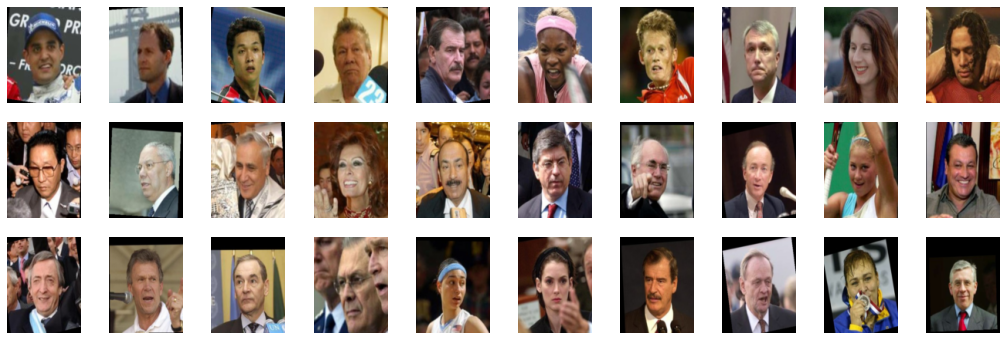

In [11]:
plot_image_samples(X)

In [12]:
# Single Image Shape

X[0].shape

torch.Size([3, 125, 96])

# Modelling

In [13]:
from tensorflow import keras

In [16]:
# Encoder Model

class Encoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, input_shape=IMAGE_SHAPE, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.input_shape = input_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2) 
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2) 
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2) 
        self.l4 = nn.Conv1d(in_channels=128, out_channels=3, kernel_size=(1,1)) 
        self.mu = nn.Linear(in_features=462, out_features=latent_dims) 
        self.log_var = nn.Linear(in_features=462, out_features=latent_dims) # Modelling with zero covariance b/n all latent dims.

        with torch.no_grad():
            self.l1.weight = nn.Parameter(torch.normal(0, 0.1, self.l1.weight.shape))
            self.l2.weight = nn.Parameter(torch.normal(0, 0.1, self.l2.weight.shape))
            self.l3.weight = nn.Parameter(torch.normal(0, 0.1, self.l3.weight.shape))
            self.l4.weight = nn.Parameter(torch.normal(0, 0.1, self.l4.weight.shape))
            self.mu.weight = nn.Parameter(torch.normal(0, 0.1, self.mu.weight.shape))
            self.log_var.weight = nn.Parameter(torch.normal(0, 0.1, self.log_var.weight.shape))
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x)) # [None, 32, 62, 47]
        x = f(self.l2(x)) # [None, 64, 30, 23]
        x = f(self.l3(x)) # [None, 128, 14, 11]
        x = f(self.l4(x)) # [None, 3, 14, 11]
        x = torch.flatten(x, start_dim=1)   # [None, 3*14*11=462]

        # Data Distribution Parameters
        mu = self.mu(x)       # [None, latent_dims]
        log_var = self.log_var(x) # [None, latent_dims]

        return [mu, log_var]

In [17]:
# Encoder Summary

print(summary(Encoder(), torch.zeros((1, *IMAGE_SHAPE)), show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 125, 96]             896             896
          Conv2d-2      [1, 32, 62, 47]          18,496          18,496
          Conv2d-3      [1, 64, 30, 23]          73,856          73,856
          Conv1d-4     [1, 128, 14, 11]             387             387
          Linear-5             [1, 462]          14,816          14,816
          Linear-6             [1, 462]          14,816          14,816
Total params: 123,267
Trainable params: 123,267
Non-trainable params: 0
------------------------------------------------------------------------


In [18]:
# Decoder Model

class Decoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, output_shape=IMAGE_SHAPE, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.output_shape = output_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Linear(in_features=latent_dims, out_features=4*latent_dims)
        self.l2 = nn.Linear(in_features=4*latent_dims, out_features=8*latent_dims)
        self.l3 = nn.Linear(in_features=8*latent_dims, out_features=21*latent_dims)
        self.l4 = nn.ConvTranspose2d(in_channels=2, out_channels=output_shape[0], kernel_size=(3,3), stride=3)
        self.l5 = nn.ConvTranspose2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(3,3), stride=2)
        self.l6 = nn.Conv2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(3,2))

        with torch.no_grad():
            self.l1.weight = nn.Parameter(torch.normal(0, 0.1, self.l1.weight.shape))
            self.l2.weight = nn.Parameter(torch.normal(0, 0.1, self.l2.weight.shape))
            self.l3.weight = nn.Parameter(torch.normal(0, 0.1, self.l3.weight.shape))
            self.l4.weight = nn.Parameter(torch.normal(0, 0.1, self.l4.weight.shape))
            self.l5.weight = nn.Parameter(torch.normal(0, 0.1, self.l5.weight.shape))
            self.l6.weight = nn.Parameter(torch.normal(0, 0.1, self.l6.weight.shape))
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x))     # [None, latent_dim*4]
        x = f(self.l2(x))     # [None, latent_dim*8]
        x = f(self.l3(x))     # [None, latent_dim*16]
        x = torch.reshape(x, (-1, 2, 5+self.latent_dims//2, self.latent_dims//2)) # [None, 2, 21, 16]
        x = f(self.l4(x))     # [None, 3, 63, 48]
        x = f(self.l5(x))     # [None, 3, 127, 97]
        x = torch.sigmoid(self.l6(x))     # [None, 3, 125, 96]
        return x

In [19]:
# Decoder Summary

print(summary(Decoder(), torch.zeros((1, LATENT_DIMS)), show_input=True))

-------------------------------------------------------------------------
        Layer (type)         Input Shape         Param #     Tr. Param #
            Linear-1             [1, 32]           4,224           4,224
            Linear-2            [1, 128]          33,024          33,024
            Linear-3            [1, 256]         172,704         172,704
   ConvTranspose2d-4      [1, 2, 21, 16]              57              57
   ConvTranspose2d-5      [1, 3, 63, 48]              84              84
            Conv2d-6     [1, 3, 127, 97]              57              57
Total params: 210,150
Trainable params: 210,150
Non-trainable params: 0
-------------------------------------------------------------------------


KL divergence between two Gaussian is defined as

$$KL(p||q) = {1 \over 2}\Bigg(\log\Bigg( \frac{|\Sigma_2|}{|\Sigma_1|}\Bigg)  -n + Trace\Big(\Sigma_2^{-1}\Sigma_1 \Big) + (\mu_2 - \mu_1)^T\Sigma_2^{-1}(\mu_2 - \mu_1)\Bigg)$$

where $P \sim N(\mu_1, \Sigma_1)$ and $Q \sim N(\mu_2, \Sigma_2)$.

In our case $Q = N(\vec0, \mathbb{I})$. It reduces KL to

$$KL(p||q) = {1 \over 2}\Bigg(-\log\big( |\Sigma_1|\big)  -n + Trace\Big(\Sigma_1 \Big) + \mu_1^2\Bigg)$$

In [20]:
MSE = lambda x, y, reduction: torch.sum(torch.square(x-y)) if reduction=="sum" else torch.mean(torch.square(x-y))

In [21]:
# Variational AutoEncoder

class VAE(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, image_shape=IMAGE_SHAPE, beta=10.0, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.encoder = Encoder(latent_dims, image_shape)
        self.decoder = Decoder(latent_dims, image_shape)
        self.beta = beta

        self.kl_loss = None
        self.reconstr_loss = None

    def forward(self, x):
        # Get Data Distribution's Parameters
        mu, log_var = self.encoder(x)
        
        # Reparameterization Trick
        z = mu + torch.exp(0.5*log_var)*torch.randn_like(mu) if self.training else mu

        # Reocnstruct Data points using latent space embeddings.
        reconstructed_x = self.decoder(z)
        
        if self.training:
            # We can use any metric function here.
            #self.reconstr_loss = NegLogLik(reconstructed_x, x, reduction="mean")
            #self.reconstr_loss = MSE(reconstructed_x, x, reduction="mean")
            self.reconstr_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
            
            self.kl_loss = self.beta * 0.5 * torch.sum(-log_var - 1 + torch.exp(log_var) + torch.square(mu))
    
        return reconstructed_x, mu, log_var


In [22]:
# Model Instantiation
model = VAE(beta=1)
model = model.to(device)

# Forward Propagation
X_bar, _, _ = model.forward(X.to(device))

In [23]:
# VAE Summary

print(summary(VAE(), torch.zeros((1, *IMAGE_SHAPE)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Encoder-1     [1, 3, 125, 96]         123,267         123,267
         Decoder-2             [1, 32]         210,150         210,150
Total params: 333,417
Trainable params: 333,417
Non-trainable params: 0
-----------------------------------------------------------------------


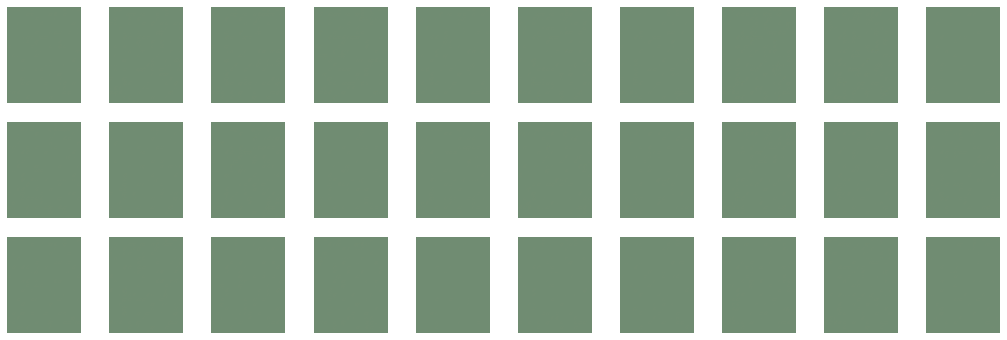

In [24]:
# Output of untrained VAE

plot_image_samples(X_bar[:].detach().cpu())

# Training Loop

In [25]:
# Training Params

opt = torch.optim.Adam(model.parameters())
EPOCHS = 100
THRESHOLD = 1e-4
PATIENCE = 8

history = {'recon-loss': [0], 'kl-loss': [0]}

Epoch [1 / 100] 
    - KL-Loss:  1.924635 
    - Recon-Loss:  755762.923158 
    - Total-Loss:  755764.847793
    - Time-Taken:  42.688859 sec

Epoch [2 / 100] 
    - KL-Loss:  0.870157 
    - Recon-Loss:  748417.964447 
    - Total-Loss:  748418.834604
    - Time-Taken:  42.521658 sec

Epoch [3 / 100] 
    - KL-Loss:  0.845906 
    - Recon-Loss:  747429.827370 
    - Total-Loss:  747430.673276
    - Time-Taken:  43.084905 sec

Epoch [4 / 100] 
    - KL-Loss:  0.967016 
    - Recon-Loss:  747189.964372 
    - Total-Loss:  747190.931388
    - Time-Taken:  43.132795 sec

Epoch [5 / 100] 
    - KL-Loss:  1.071701 
    - Recon-Loss:  746963.707126 
    - Total-Loss:  746964.778827
    - Time-Taken:  43.208457 sec



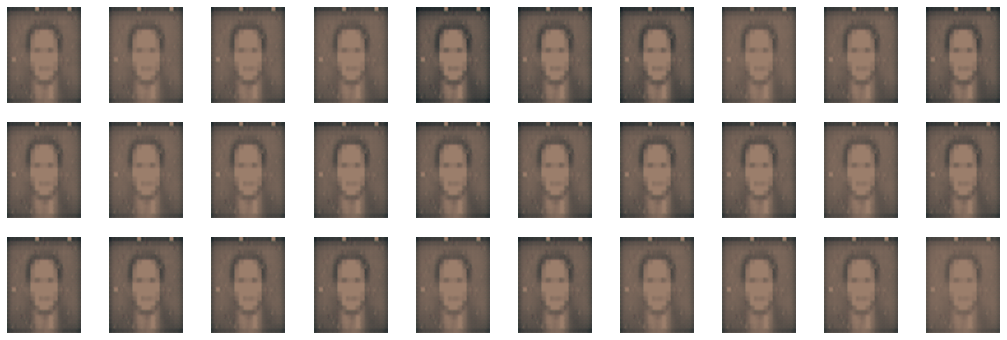


Epoch [6 / 100] 
    - KL-Loss:  1.292370 
    - Recon-Loss:  746766.456899 
    - Total-Loss:  746767.749269
    - Time-Taken:  42.256845 sec

Epoch [7 / 100] 
    - KL-Loss:  1.574976 
    - Recon-Loss:  746603.608167 
    - Total-Loss:  746605.183144
    - Time-Taken:  42.105556 sec

Epoch [8 / 100] 
    - KL-Loss:  2.000860 
    - Recon-Loss:  746534.760568 
    - Total-Loss:  746536.761428
    - Time-Taken:  42.080827 sec

Epoch [9 / 100] 
    - KL-Loss:  2.701957 
    - Recon-Loss:  746331.680103 
    - Total-Loss:  746334.382060
    - Time-Taken:  42.103987 sec

Epoch [10 / 100] 
    - KL-Loss:  3.386500 
    - Recon-Loss:  746187.783590 
    - Total-Loss:  746191.170090
    - Time-Taken:  42.374617 sec



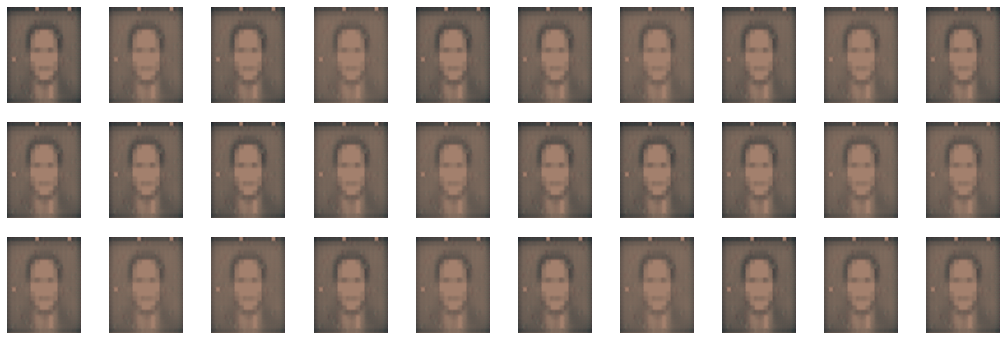


Epoch [11 / 100] 
    - KL-Loss:  4.168478 
    - Recon-Loss:  746055.458333 
    - Total-Loss:  746059.626812
    - Time-Taken:  42.276015 sec

Epoch [12 / 100] 
    - KL-Loss:  5.069631 
    - Recon-Loss:  745860.886549 
    - Total-Loss:  745865.956180
    - Time-Taken:  42.151187 sec

Epoch [13 / 100] 
    - KL-Loss:  5.944592 
    - Recon-Loss:  745832.378548 
    - Total-Loss:  745838.323140
    - Time-Taken:  42.085106 sec

Epoch [14 / 100] 
    - KL-Loss:  6.825701 
    - Recon-Loss:  745777.020079 
    - Total-Loss:  745783.845779
    - Time-Taken:  42.763949 sec

Epoch [15 / 100] 
    - KL-Loss:  7.551494 
    - Recon-Loss:  745638.600242 
    - Total-Loss:  745646.151736
    - Time-Taken:  42.532483 sec



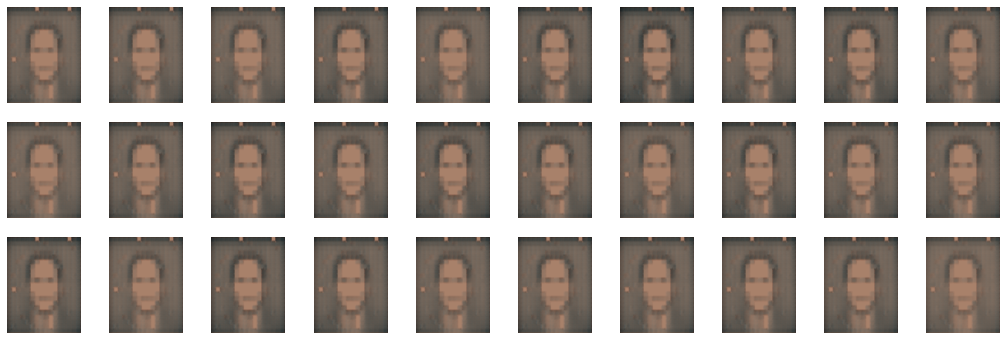


Epoch [16 / 100] 
    - KL-Loss:  8.548966 
    - Recon-Loss:  745558.865338 
    - Total-Loss:  745567.414305
    - Time-Taken:  41.777270 sec

Epoch [17 / 100] 
    - KL-Loss:  9.656477 
    - Recon-Loss:  745444.245094 
    - Total-Loss:  745453.901571
    - Time-Taken:  41.572413 sec

Epoch [18 / 100] 
    - KL-Loss:  10.841472 
    - Recon-Loss:  745247.029287 
    - Total-Loss:  745257.870760
    - Time-Taken:  41.571332 sec

Epoch [19 / 100] 
    - KL-Loss:  11.950640 
    - Recon-Loss:  745488.238527 
    - Total-Loss:  745500.189167
    - Time-Taken:  41.441200 sec

Epoch [20 / 100] 
    - KL-Loss:  12.797170 
    - Recon-Loss:  745364.396664 
    - Total-Loss:  745377.193834
    - Time-Taken:  41.284645 sec



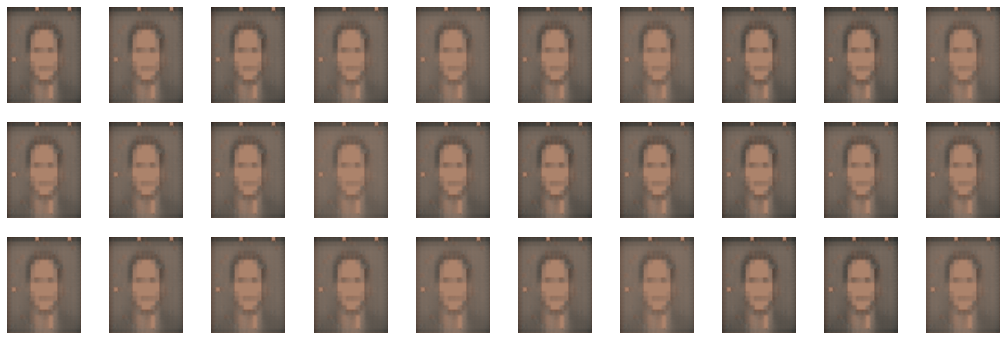


Epoch [21 / 100] 
    - KL-Loss:  13.723469 
    - Recon-Loss:  745405.636322 
    - Total-Loss:  745419.359791
    - Time-Taken:  41.403441 sec

Epoch [22 / 100] 
    - KL-Loss:  14.594330 
    - Recon-Loss:  745343.930556 
    - Total-Loss:  745358.524886
    - Time-Taken:  41.300004 sec

Epoch [23 / 100] 
    - KL-Loss:  15.613395 
    - Recon-Loss:  745356.904287 
    - Total-Loss:  745372.517683
    - Time-Taken:  41.085862 sec

Epoch [24 / 100] 
    - KL-Loss:  16.604025 
    - Recon-Loss:  745159.780571 
    - Total-Loss:  745176.384596
    - Time-Taken:  41.752513 sec

Epoch [25 / 100] 
    - KL-Loss:  17.094873 
    - Recon-Loss:  745147.653986 
    - Total-Loss:  745164.748858
    - Time-Taken:  42.060495 sec



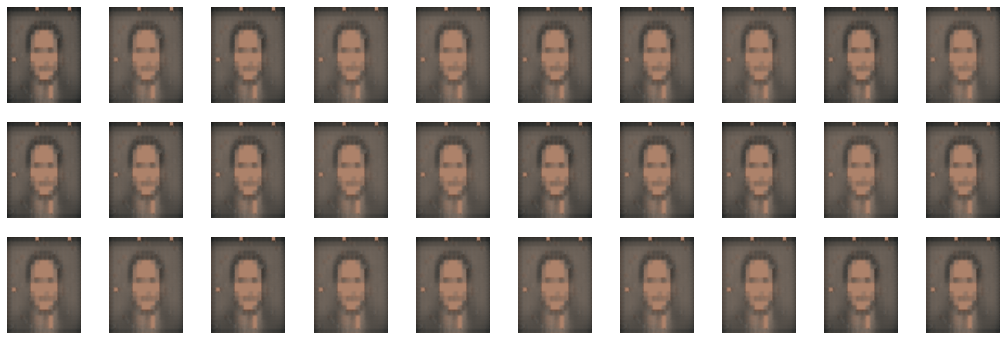


Epoch [26 / 100] 
    - KL-Loss:  17.671859 
    - Recon-Loss:  745246.892512 
    - Total-Loss:  745264.564371
    - Time-Taken:  42.822520 sec

Epoch [27 / 100] 
    - KL-Loss:  18.195588 
    - Recon-Loss:  745126.000000 
    - Total-Loss:  745144.195588
    - Time-Taken:  41.942341 sec

Epoch [28 / 100] 
    - KL-Loss:  18.138101 
    - Recon-Loss:  745003.648702 
    - Total-Loss:  745021.786803
    - Time-Taken:  41.824776 sec

Epoch [29 / 100] 
    - KL-Loss:  17.965965 
    - Recon-Loss:  745049.701766 
    - Total-Loss:  745067.667731
    - Time-Taken:  42.538627 sec

Epoch [30 / 100] 
    - KL-Loss:  17.665268 
    - Recon-Loss:  745049.036685 
    - Total-Loss:  745066.701953
    - Time-Taken:  42.429720 sec



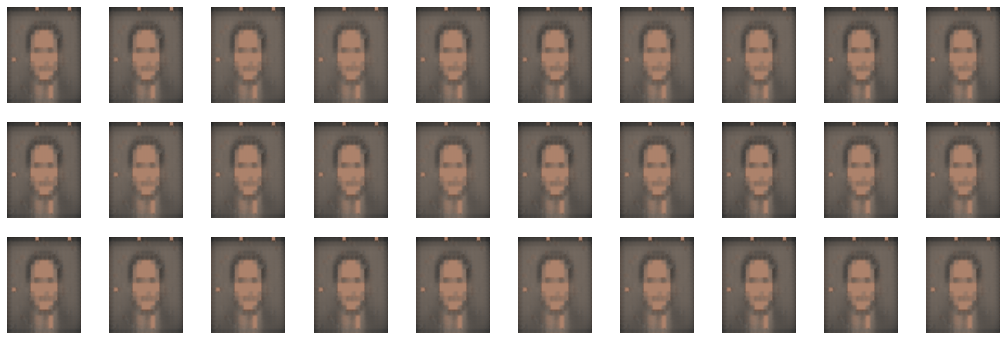


Epoch [31 / 100] 
    - KL-Loss:  17.428706 
    - Recon-Loss:  745034.797932 
    - Total-Loss:  745052.226637
    - Time-Taken:  42.144729 sec

Epoch [32 / 100] 
    - KL-Loss:  17.296775 
    - Recon-Loss:  745080.510266 
    - Total-Loss:  745097.807041
    - Time-Taken:  41.631922 sec

Epoch [33 / 100] 
    - KL-Loss:  17.453143 
    - Recon-Loss:  745011.611413 
    - Total-Loss:  745029.064556
    - Time-Taken:  41.512592 sec

Epoch [34 / 100] 
    - KL-Loss:  17.327072 
    - Recon-Loss:  745014.951691 
    - Total-Loss:  745032.278762
    - Time-Taken:  41.418103 sec

Epoch [35 / 100] 
    - KL-Loss:  16.787068 
    - Recon-Loss:  745010.563330 
    - Total-Loss:  745027.350398
    - Time-Taken:  42.102776 sec



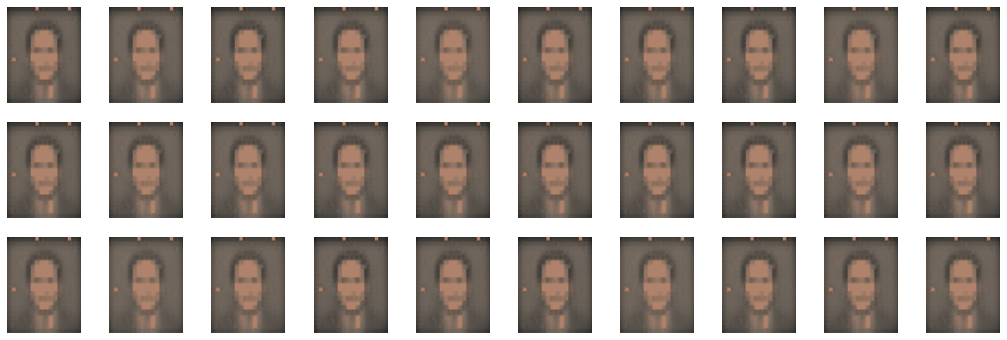


Epoch [36 / 100] 
    - KL-Loss:  16.216371 
    - Recon-Loss:  744935.347373 
    - Total-Loss:  744951.563744
    - Time-Taken:  42.736955 sec

Epoch [37 / 100] 
    - KL-Loss:  15.409328 
    - Recon-Loss:  744977.364432 
    - Total-Loss:  744992.773761
    - Time-Taken:  41.501817 sec



In [ ]:
# Custom Training Loop

model.train()

round = 0
loss_inc_count = 0

for epoch in range(EPOCHS):
    count = 0
    tick = time()
    l1, l2 = 0, 0

    for idx, X in enumerate(data):
        count += 1

        # Copy data to Device
        X = X[0].to(device)

        # Forward Pass
        reconstructed_x, mu, log_var = model.forward(X)
        
        # Loss Calculation
        rec_loss = model.reconstr_loss
        kl_loss = model.kl_loss
        loss = rec_loss + kl_loss
        
        # Backpropagation
        opt.zero_grad()
        loss.backward()
        
        # Apply Jacobians to Weights
        opt.step()

        l1 += rec_loss.item()
        l2 += kl_loss.item()
        
    # Log Training
    history["recon-loss"].append(l1/count)
    history["kl-loss"].append(l2/count)
    
    # Training Moniotring
    tock = time()
    round += 1
    print(f"""Epoch [{round} / {EPOCHS}] 
    - KL-Loss: {history["kl-loss"][-1]: 0.6f} 
    - Recon-Loss: {history["recon-loss"][-1]: 0.6f} 
    - Total-Loss: {(history["kl-loss"][-1] + history["recon-loss"][-1]): 0.6f}
    - Time-Taken: {(tock-tick): 0.6f} sec""", end="\n\n")
    
    # Plot Randomly Sampled Latent Embeddings
    if round%5 == 0:
        plot_image_samples(model.decoder(torch.randn((32, LATENT_DIMS)).to(device)).detach().cpu())
        print()

    # Early Stopping
    if (history["kl-loss"][-1]  - history["kl-loss"][-2] + history["recon-loss"][-1] - history["recon-loss"][-2]) < 0:
        loss_inc_count += 0
    if ((abs(history["kl-loss"][-1]  - history["kl-loss"][-2]) + abs(history["recon-loss"][-1] - history["recon-loss"][-2])) <= THRESHOLD) or (loss_inc_count >= PATIENCE):
        break

In [ ]:
# Training Visualization

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(history["recon-loss"])
plt.title("Recostruction Loss")

plt.subplot(1, 3, 2)
plt.plot(history["kl-loss"])
plt.title("KL Loss")

plt.subplot(1, 3, 3)
plt.plot(history["recon-loss"]+history["kl-loss"])
plt.title("Total Loss")

plt.show()

In [ ]:
# Visualizing Latent Space

N = 1000 #No of Parameters
N_sample = 3 #No. of Samples per parameter

# Sampling Images
temp = [next(iter(data)) for _ in range(N//32 + 1)]
X = torch.vstack([x[0] for x in temp])
Y = torch.hstack([x[1] for x in temp])

# Forward Pass through Encoder
mu_, _log_var = model.encoder(X.to(device))

# Sampling from Normal Disitrbution using predicted Parameters
embeddings = torch.vstack([torch.normal(mu_, 0.5*torch.exp(_log_var)) for _ in range(N_sample)]).detach().cpu().numpy()
embedding_class = torch.hstack([Y for _ in range(N_sample)]).detach().cpu().numpy()

# Dimensionality Reduction
low_dim_embeddings = KernelPCA(n_components=2, kernel="poly").fit_transform(embeddings)

# Plotting Principle Components
plt.figure(figsize=(16,8))
plt.scatter(x = low_dim_embeddings[:,0], 
            y = low_dim_embeddings[:, 1], 
            alpha=0.6)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

# Checkpointing

In [ ]:
# Saving Model

# torch.save(model.state_dict(), "./brain-tumor-vae.pt")